In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Homeworks FDS/Progetto

/content/drive/.shortcut-targets-by-id/1Vzw8m8Ha_VscaXjjIlDjZrQtp1m45M3N/Homeworks FDS/Progetto


In [3]:
%pwd

'/content/drive/.shortcut-targets-by-id/1Vzw8m8Ha_VscaXjjIlDjZrQtp1m45M3N/Homeworks FDS/Progetto'

Packages and utility functions

In [4]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math
from scipy.ndimage import convolve1d
from PIL import Image
import random
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
def rgb2gray(rgb: np.ndarray) -> np.ndarray:
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [6]:
def normalize_histogram_minmax(histogram):
    hist_min = np.min(histogram)
    hist_max = np.max(histogram)
    return (histogram - hist_min) / (hist_max - hist_min) if hist_max > hist_min else histogram

In [7]:
def adjust_hist(hist):
    idx = np.argmax(hist)
    hist[idx] = np.mean(hist)

    return normalize_histogram_minmax(hist)

In [8]:
artificial_path = "./6k_samples_dataset/dataset/artificial"
natural_path = "./6k_samples_dataset/dataset/natural"

num_bins = 10

# Gaussian partial derivatives functions

In [ ]:
def gauss(sigma: float, filter_size: int):
    x = np.arange(-filter_size//2,filter_size//2 + 1)
    Gx = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5*(x**2)/(sigma**2))
    return Gx, x

In [ ]:
def gaussdx(sigma: float):
    filter_size = int(np.ceil(6 * sigma)) + 1

    zero_pos = filter_size // 2
    x = np.arange(filter_size) - zero_pos
    Dx = -x * np.exp(-(x**2) / (2.0 * sigma**2)) / (math.sqrt(2.0 * np.pi) * sigma**3)

    return Dx, x

In [ ]:
def gauss_dxdy(img: np.ndarray, sigma: float):

    Gx, _ = gauss(sigma, filter_size=6*sigma)
    Dx, _ = gaussdx(sigma)

    img_Dx = convolve1d(convolve1d(img, Dx, axis=1), Gx, axis=0)
    img_Dy = convolve1d(convolve1d(img, Dx, axis=0), Gx, axis=1)

    return img_Dx, img_Dy

In [ ]:
def hist_dxdy(img_gray, num_bins=5):

    assert len(img_gray.shape) == 2, "image dimension mismatch"
    assert img_gray.dtype == "float", "incorrect image type"

    sigma = 3.0
    img_dx, img_dy = gauss_dxdy(img_gray, sigma)

    min_der, max_der = (-6, 6)

    img_dx = img_dx.reshape(-1)
    img_dy = img_dy.reshape(-1)

    img_dx = np.clip(img_dx, min_der, max_der) - min_der
    img_dy = np.clip(img_dy, min_der, max_der) - min_der

    hists = np.zeros((num_bins, num_bins), dtype=int)
    bin_range = (max_der - min_der) / num_bins

    bin_dx = np.floor(img_dx / bin_range).astype(int)
    bin_dy = np.floor(img_dy / bin_range).astype(int)
    bin_dx = np.clip(bin_dx, 0, num_bins - 1)
    bin_dy = np.clip(bin_dy, 0, num_bins - 1)

    for i in range(bin_dx.size):
        hists[bin_dx[i], bin_dy[i]] += 1

    hists = hists / np.sum(hists)
    return hists.ravel()

# Color histograms functions

In [ ]:
def rb_hist(img_color_double: np.ndarray, num_bins: int = 5) -> np.ndarray:

    bin_edges = np.linspace(0, 256, num_bins + 1)

    R = img_color_double[:, :, 0].flatten()
    B = img_color_double[:, :, 2].flatten()

    R_bins = np.digitize(R, bin_edges) - 1
    B_bins = np.digitize(B, bin_edges) - 1

    hists = np.zeros((num_bins, num_bins), dtype=int)

    for r_bin, b_bin in zip(R_bins, B_bins):
        if 0 <= r_bin < num_bins and 0 <= b_bin < num_bins:
            hists[r_bin, b_bin] += 1

    hists = hists / hists.sum()

    hists = hists.flatten()

    return hists

# Mean histograms

In [ ]:
def compute_mean_dxdy_histogram(folder_path, num_bins):
    histograms = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img_color = np.array(Image.open(img_path))
            img_gray = rgb2gray(img_color.astype("double"))
            hist = hist_dxdy(img_gray, num_bins)
            histograms.append(hist)
    return histograms, np.mean(histograms, axis=0) if histograms else np.zeros(num_bins * num_bins)

In [ ]:
def compute_mean_rb_histogram(folder_path, num_bins):
    histograms = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img_color = np.array(Image.open(img_path))
            hist = rb_hist(img_color, num_bins)
            histograms.append(hist)
    return histograms, np.mean(histograms, axis=0) if histograms else np.zeros(num_bins * num_bins)

Plot one natural and one artificial dxdy histogram randomly

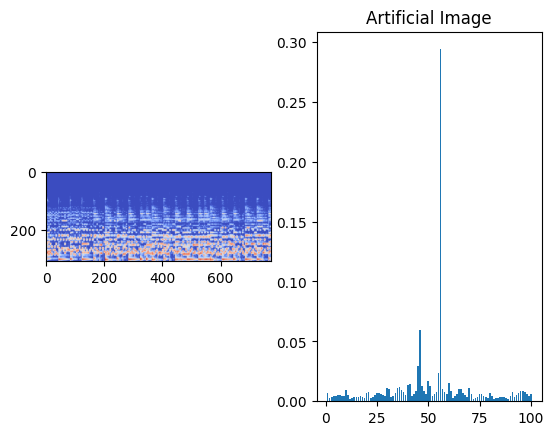

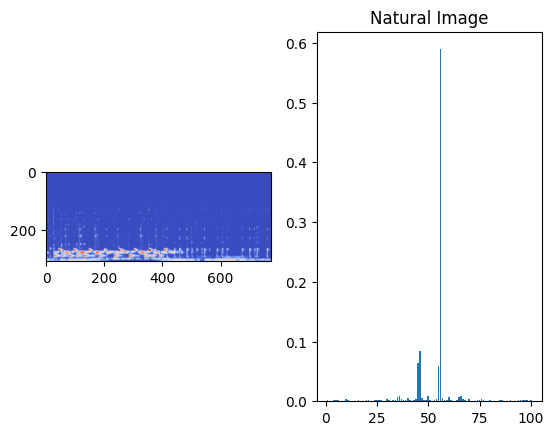

In [ ]:
img = random.choice(os.listdir(artificial_path))
img = os.path.join(artificial_path, img)
img_color = np.array(Image.open(img))
img_gray = rgb2gray(img_color.astype("double"))

plt.figure(5)
plt.subplot(1, 2, 1)
plt.imshow(img_color)

plt.subplot(1, 2, 2)
hist_dxdy_ = hist_dxdy(img_gray, num_bins)
plt.bar(np.array(range(1, hist_dxdy_.size + 1)), hist_dxdy_)
plt.title("Artificial Image")
plt.show()

img = random.choice(os.listdir(natural_path))
img = os.path.join(natural_path, img)
img_color = np.array(Image.open(img))
img_gray = rgb2gray(img_color.astype("double"))

plt.figure(5)
plt.subplot(1, 2, 1)
plt.imshow(img_color)

plt.subplot(1, 2, 2)
hist_dxdy_ = hist_dxdy(img_gray, num_bins)
plt.bar(np.array(range(1, hist_dxdy_.size + 1)), hist_dxdy_)
plt.title("Natural Image")
plt.show()

Plot one natural and one artificial color histogram randomly

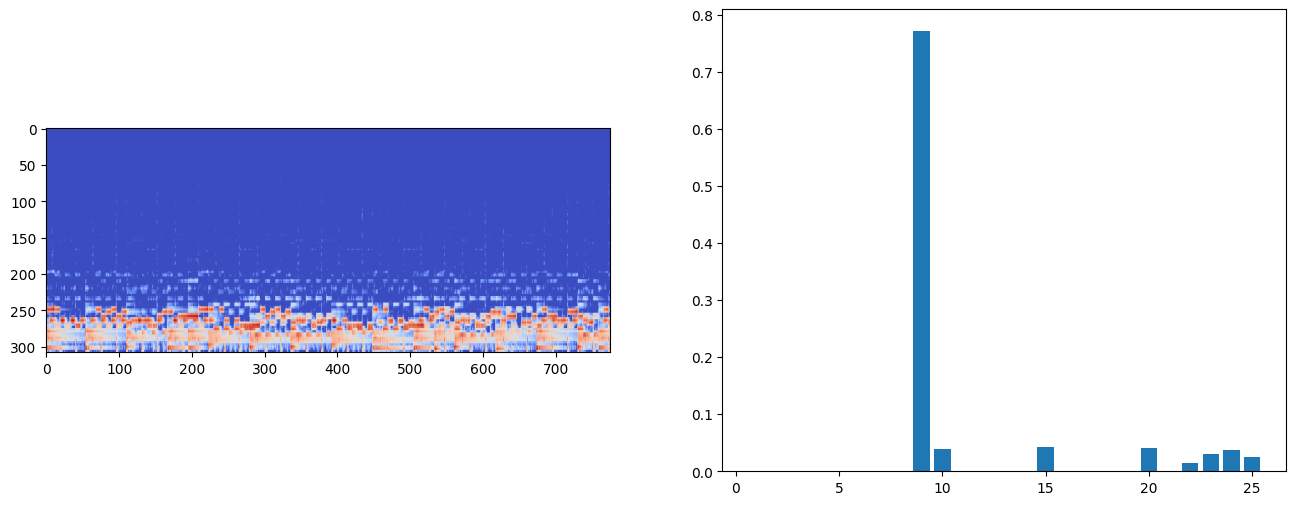

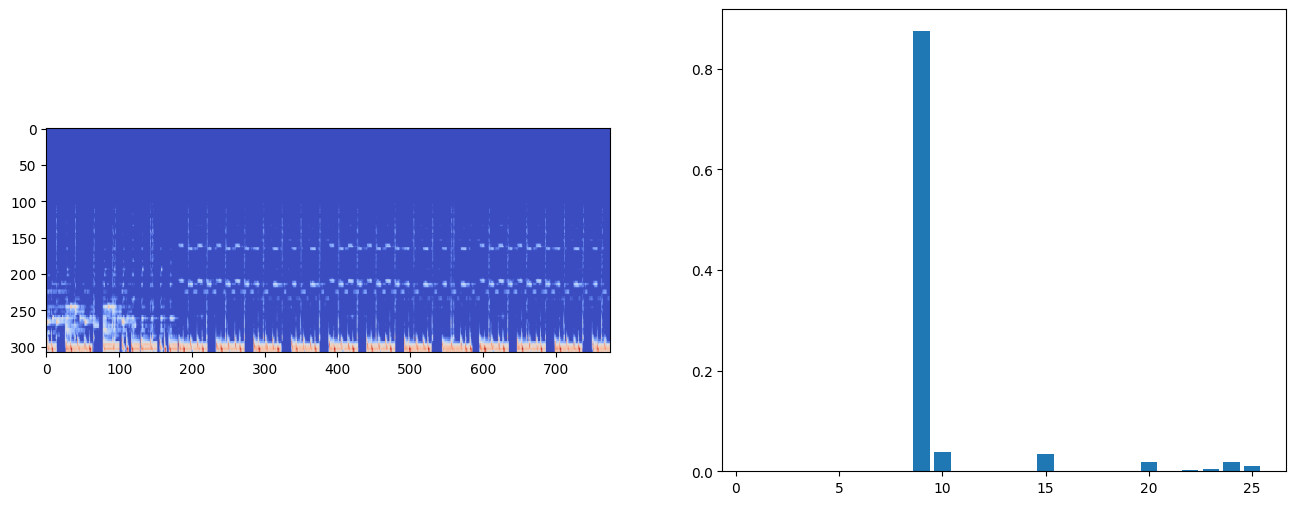

In [ ]:
img = random.choice(os.listdir(artificial_path))
img = os.path.join(artificial_path, img)
img_color = np.array(Image.open(img))

plt.figure(3, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_color)

num_bins_color = 5
plt.subplot(1, 2, 2)
hist_gb = rb_hist(img_color.astype("double"), num_bins_color)
plt.bar(np.array(range(1, hist_gb.size + 1)), hist_gb)
plt.show()

img = random.choice(os.listdir(natural_path))
img = os.path.join(natural_path, img)
img_color = np.array(Image.open(img))

plt.figure(3, figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_color)

num_bins_color = 5
plt.subplot(1, 2, 2)
hist_gb = rb_hist(img_color.astype("double"), num_bins_color)
plt.bar(np.array(range(1, hist_gb.size + 1)), hist_gb)
plt.show()

## Compute average dxdy histograms for both classes

In [ ]:
dxdy_hists_artificial, mean_dxdy_hist_artificial = compute_mean_dxdy_histogram(artificial_path, num_bins)
dxdy_hists_natural, mean_dxdy_hist_natural = compute_mean_dxdy_histogram(natural_path, num_bins)

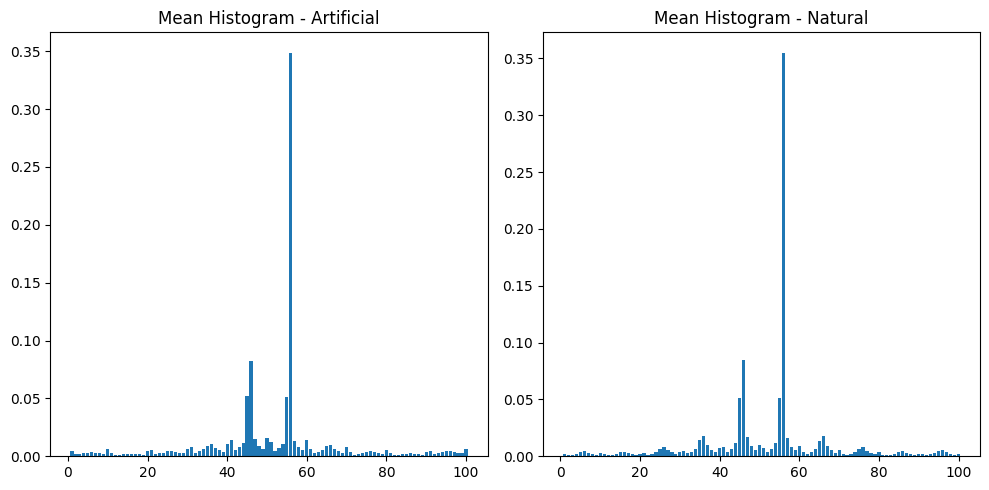

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, mean_dxdy_hist_artificial.size + 1), mean_dxdy_hist_artificial)
plt.title("Mean Histogram - Artificial")

plt.subplot(1, 2, 2)
plt.bar(range(1, mean_dxdy_hist_natural.size + 1), mean_dxdy_hist_natural)
plt.title("Mean Histogram - Natural")

plt.tight_layout()
plt.show()

Adjust and remove the peak

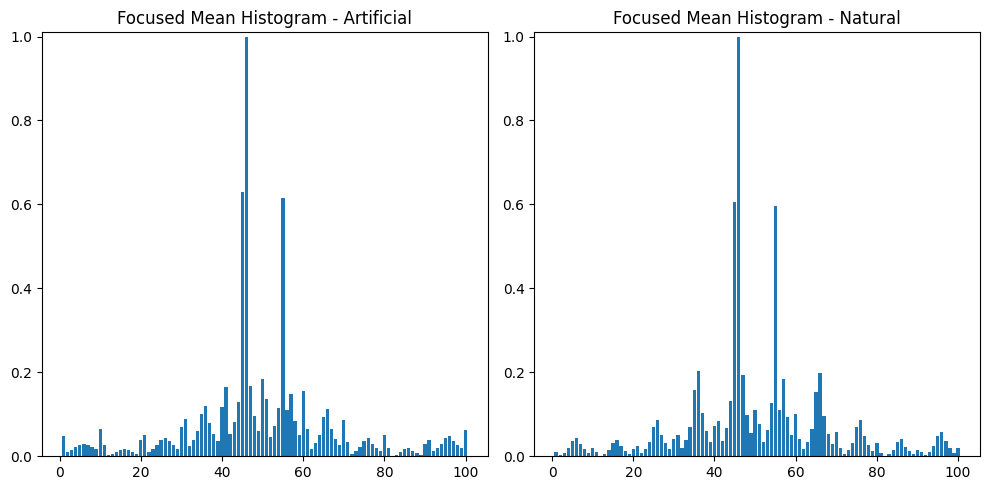

In [ ]:
adj_mean_dxdy_hist_artificial = adjust_hist(mean_dxdy_hist_artificial)
adj_mean_dxdy_hist_natural = adjust_hist(mean_dxdy_hist_natural)

y_max = max(adj_mean_dxdy_hist_artificial.max(), adj_mean_dxdy_hist_natural.max()) + 0.01

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, adj_mean_dxdy_hist_artificial.size + 1), adj_mean_dxdy_hist_artificial)
plt.title("Focused Mean Histogram - Artificial")
plt.ylim(0, y_max)

plt.subplot(1, 2, 2)
plt.bar(range(1, adj_mean_dxdy_hist_natural.size + 1), adj_mean_dxdy_hist_natural)
plt.title("Focused Mean Histogram - Natural")
plt.ylim(0, y_max)

plt.tight_layout()
plt.show()

## Compute average color histograms for both classes

In [ ]:
rb_hists_artificial, mean_rb_hist_artificial = compute_mean_rb_histogram(artificial_path, num_bins)
rb_hists_natural, mean_rb_hist_natural = compute_mean_rb_histogram(natural_path, num_bins)

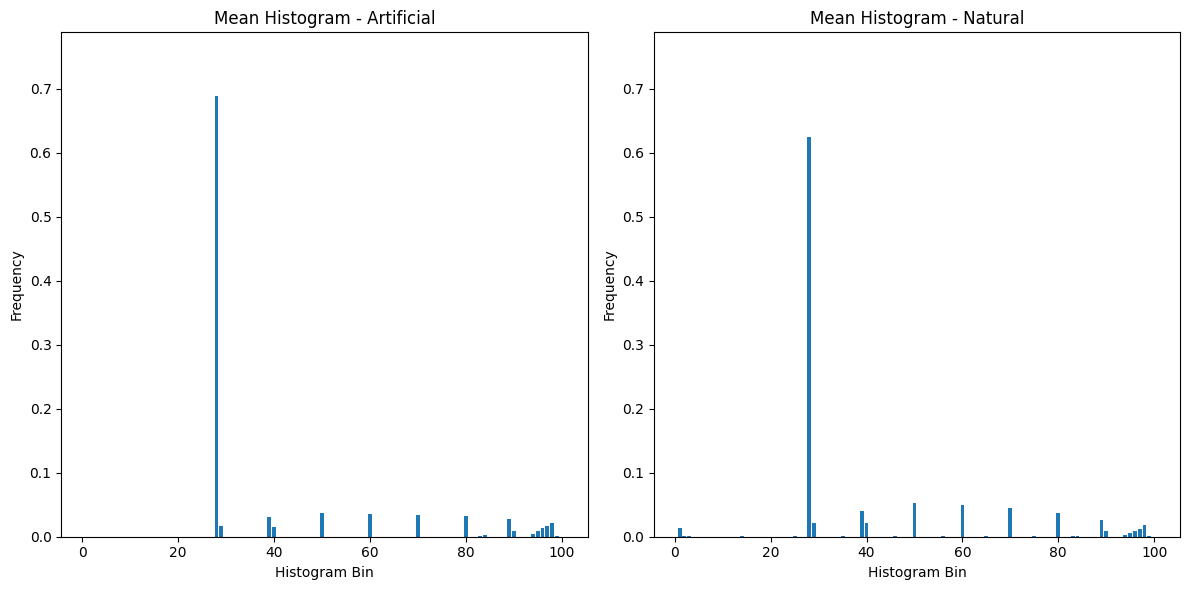

In [ ]:
y_max = max(mean_rb_hist_artificial.max(), mean_rb_hist_natural.max()) + 0.1

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, mean_rb_hist_artificial.size + 1), mean_rb_hist_artificial)
plt.title("Mean Histogram - Artificial")
plt.xlabel("Histogram Bin")
plt.ylabel("Frequency")
plt.ylim(0, y_max)

plt.subplot(1, 2, 2)
plt.bar(range(1, mean_rb_hist_natural.size + 1), mean_rb_hist_natural)
plt.title("Mean Histogram - Natural")
plt.xlabel("Histogram Bin")
plt.ylabel("Frequency")
plt.ylim(0, y_max)

plt.tight_layout()
plt.show()

Adjust and remove the peaks

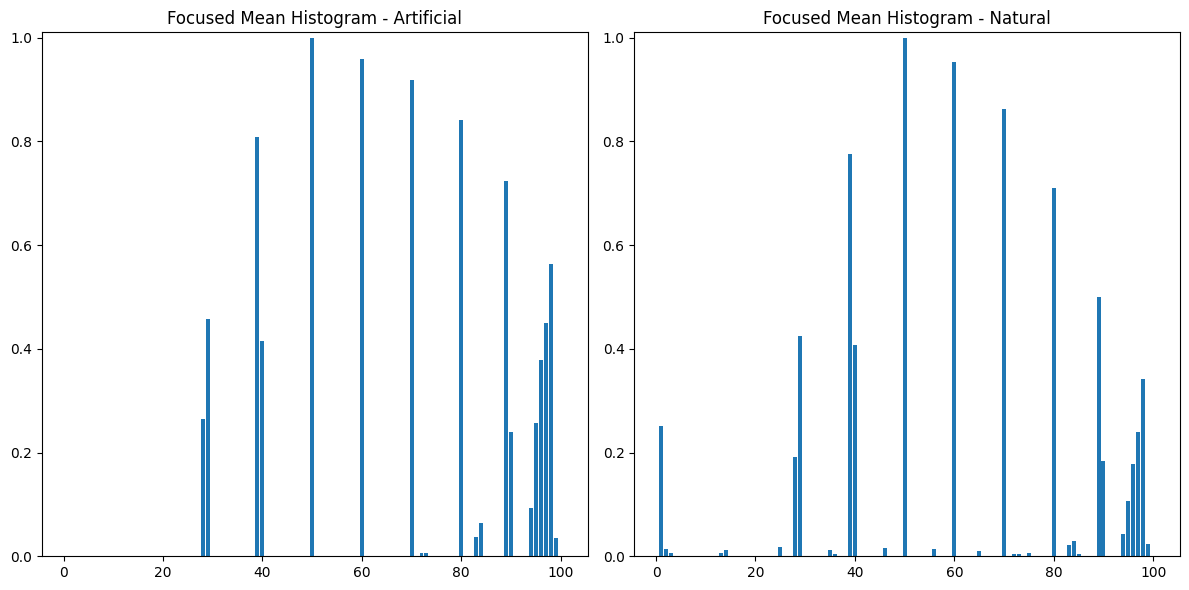

In [ ]:
adj_mean_rb_hist_artificial = adjust_hist(mean_rb_hist_artificial)
adj_mean_rb_hist_natural = adjust_hist(mean_rb_hist_natural)

y_max = max(adj_mean_rb_hist_artificial.max(), adj_mean_rb_hist_natural.max()) + 0.01

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(1, adj_mean_rb_hist_artificial.size + 1), adj_mean_rb_hist_artificial)
plt.title("Focused Mean Histogram - Artificial")
plt.ylim(0, y_max)

plt.subplot(1, 2, 2)
plt.bar(range(1, adj_mean_rb_hist_natural.size + 1), adj_mean_rb_hist_natural)
plt.title("Focused Mean Histogram - Natural")
plt.ylim(0, y_max)

plt.tight_layout()
plt.show()

**OPTIONAL TO SAVE DATA AND LOAD IT WITHOUT COMPUTING AGAIN**
# Adjust and save histograms


In [ ]:
adjusted_dxdy_artificial = np.array(list(map(adjust_hist, dxdy_hists_artificial)))
adjusted_dxdy_natural = np.array(list(map(adjust_hist, dxdy_hists_natural)))

adjusted_rb_artificial = np.array(list(map(adjust_hist, rb_hists_artificial)))
adjusted_rb_natural = np.array(list(map(adjust_hist, rb_hists_natural)))

In [ ]:
type(adjusted_rb_artificial)

numpy.ndarray

In [ ]:
np.save('histograms/adjusted_dxdy_artificial.npy', adjusted_dxdy_artificial)
np.save('histograms/adjusted_dxdy_natural.npy', adjusted_dxdy_natural)
np.save('histograms/adjusted_rb_artificial.npy', adjusted_rb_artificial)
np.save('histograms/adjusted_rb_natural.npy', adjusted_rb_natural)

# Load data and create training and labels sets

## Dxdy hists

In [9]:
dxdy_artificial = np.load('histograms/adjusted_dxdy_artificial.npy', allow_pickle=True)
dxdy_natural = np.load('histograms/adjusted_dxdy_natural.npy', allow_pickle=True)

In [10]:
print(dxdy_artificial.shape)
print(dxdy_natural.shape)

(3000, 100)
(3000, 100)


In [11]:
X_dxdy = np.array(list(dxdy_artificial) + list(dxdy_natural))
y_dxdy = np.array([0]*dxdy_artificial.shape[0] + [1]*dxdy_natural.shape[0])

## Rb hists

In [12]:
rb_artificial = np.load('histograms/adjusted_rb_artificial.npy', allow_pickle=True)
rb_natural = np.load('histograms/adjusted_rb_natural.npy', allow_pickle=True)

In [13]:
print(rb_artificial.shape)
print(rb_natural.shape)

(3000, 100)
(3000, 100)


In [14]:
X_rb = np.array(list(rb_artificial) + list(rb_natural))
y_rb = np.array([0]*rb_artificial.shape[0] + [1]*rb_natural.shape[0])

# Histograms analysis

## Random Forest classifier

### Random forest classification from dxdy histograms

In [15]:
X_train_dxdy, X_test_dxdy, y_train_dxdy, y_test_dxdy = train_test_split(X_dxdy, y_dxdy, test_size=0.2, random_state=42)
print(f"Train size: {X_train_dxdy.shape[0]}\nTest size: {X_test_dxdy.shape[0]}")

Train size: 4800
Test size: 1200


In [16]:
rfc_dxdy = RandomForestClassifier()
rfc_dxdy.fit(X_train_dxdy, y_train_dxdy)

y_pred_dxdy = rfc_dxdy.predict(X_test_dxdy)

accuracy_dxdy = accuracy_score(y_test_dxdy, y_pred_dxdy)
print("Accuracy:", accuracy_dxdy)

Accuracy: 0.9183333333333333


In [17]:
print("Classification Report:")
print(classification_report(y_test_dxdy, y_pred_dxdy))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       613
           1       0.92      0.91      0.92       587

    accuracy                           0.92      1200
   macro avg       0.92      0.92      0.92      1200
weighted avg       0.92      0.92      0.92      1200



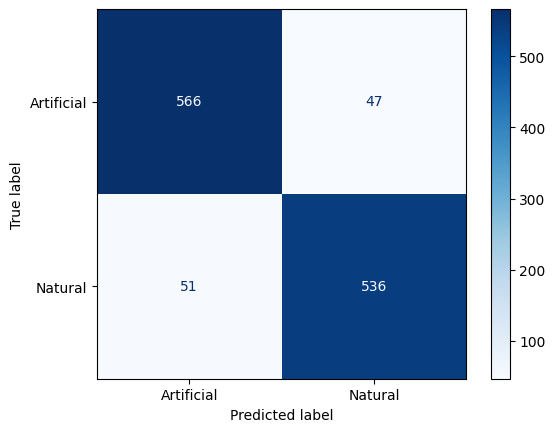

In [18]:
cm_dxdy = confusion_matrix(y_test_dxdy, y_pred_dxdy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dxdy, display_labels=["Artificial", "Natural"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Random forest classification from rb color histograms

In [19]:
X_train_rb, X_test_rb, y_train_rb, y_test_rb = train_test_split(X_rb, y_rb, test_size=0.2, random_state=42)
print(f"Train size: {X_train_rb.shape[0]}\nTest size: {X_test_rb.shape[0]}")

Train size: 4800
Test size: 1200


In [20]:
rfc_rb = RandomForestClassifier()
rfc_rb.fit(X_train_rb, y_train_rb)

y_pred_rb = rfc_rb.predict(X_test_rb)

accuracy_rb = accuracy_score(y_test_rb, y_pred_rb)
print("Accuracy:", accuracy_rb)

Accuracy: 0.83


In [21]:
print("Classification Report:")
print(classification_report(y_test_rb, y_pred_rb))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       613
           1       0.85      0.79      0.82       587

    accuracy                           0.83      1200
   macro avg       0.83      0.83      0.83      1200
weighted avg       0.83      0.83      0.83      1200



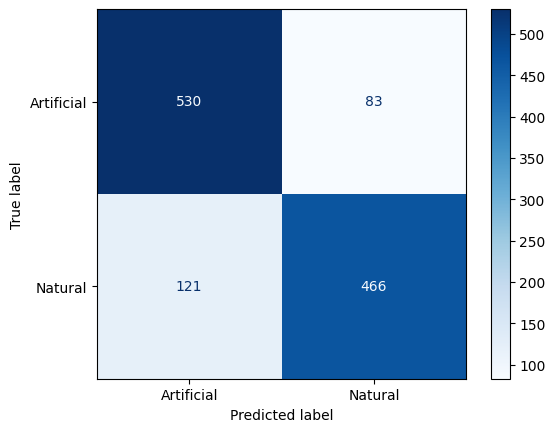

In [22]:
cm_rb = confusion_matrix(y_test_rb, y_pred_rb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rb, display_labels=["Artificial", "Natural"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Neural newtork classification

### Simple NN setup

In [23]:
class HistogramClassifier(nn.Module):
    def __init__(self, input_size=100, hidden_size=64):
        super(HistogramClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

Training and evaluation functions

In [24]:
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, num_epochs=50, batch_size=32):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        permutation = torch.randperm(X_train.size(0))
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = X_train[indices], y_train[indices]

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.view(-1, 1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / (X_train.size(0)//batch_size))

        model.eval()
        with torch.no_grad():
            outputs = model(X_val).view(-1, 1)
            val_loss = criterion(outputs, y_val)
            val_losses.append(val_loss.item())

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}")

    return model, train_losses, val_losses

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test).numpy()
        y_test_pred_labels = (y_test_pred > 0.5).astype(int).reshape(-1)

    y_test_cpu = y_test.cpu().numpy()

    accuracy = accuracy_score(y_test_cpu, y_test_pred_labels)
    precision = precision_score(y_test_cpu, y_test_pred_labels)
    recall = recall_score(y_test_cpu, y_test_pred_labels)

    print(f"Test Accuracy: {accuracy:.2f}")
    print(f"Test Precision: {precision:.2f}")
    print(f"Test Recall: {recall:.2f}")

    cm = confusion_matrix(y_test_cpu, y_test_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Artificial", "Natural"])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

### Dxdy histograms

In [25]:
scaler = StandardScaler()
X_dxdy_normalized = scaler.fit_transform(X_dxdy)

Sets creation and convertion to tensors

In [26]:
X_train_dxdy, X_test_dxdy, y_train_dxdy, y_test_dxdy = train_test_split(X_dxdy_normalized, y_dxdy, test_size=0.2, random_state=42)

X_train_dxdy, X_val_dxdy, y_train_dxdy, y_val_dxdy = train_test_split(X_train_dxdy, y_train_dxdy, test_size=0.25, random_state=42)

print(f"Train size: {X_train_dxdy.shape[0]}")
print(f"Validation size: {X_val_dxdy.shape[0]}")
print(f"Test size: {X_test_dxdy.shape[0]}")

X_train_dxdy = torch.tensor(X_train_dxdy, dtype=torch.float32)
X_val_dxdy = torch.tensor(X_val_dxdy, dtype=torch.float32)
X_test_dxdy = torch.tensor(X_test_dxdy, dtype=torch.float32).unsqueeze(1)

y_train_dxdy = torch.tensor(y_train_dxdy, dtype=torch.float32)
y_val_dxdy = torch.tensor(y_val_dxdy, dtype=torch.float32).unsqueeze(1)
y_test_dxdy = torch.tensor(y_test_dxdy, dtype=torch.float32).unsqueeze(1)

Train size: 3600
Validation size: 1200
Test size: 1200


Training

In [27]:
input_size = 100
hidden_size = 64
num_epochs = 50
batch_size = 32

model_dxdy = HistogramClassifier(input_size=input_size, hidden_size=hidden_size)

criterion = nn.BCELoss()
optimizer = optim.Adam(model_dxdy.parameters(), lr=0.001)

model_dxdy, train_losses_dxdy, val_losses_dxdy = train_model(
    model_dxdy, criterion,
    optimizer,
    X_train_dxdy,
    y_train_dxdy,
    X_val_dxdy,
    y_val_dxdy,
    num_epochs=num_epochs,
    batch_size=batch_size
)

Epoch 1/50, Loss: 0.231980562210083, Val Loss: 0.25828444957733154
Epoch 2/50, Loss: 0.04156754910945892, Val Loss: 0.17900203168392181
Epoch 3/50, Loss: 0.26715272665023804, Val Loss: 0.17485947906970978
Epoch 4/50, Loss: 0.05257533863186836, Val Loss: 0.1530863642692566
Epoch 5/50, Loss: 0.0857955738902092, Val Loss: 0.14487072825431824
Epoch 6/50, Loss: 0.018276827409863472, Val Loss: 0.15054498612880707
Epoch 7/50, Loss: 0.16654656827449799, Val Loss: 0.1355879008769989
Epoch 8/50, Loss: 0.05298060178756714, Val Loss: 0.1393882930278778
Epoch 9/50, Loss: 0.04172137379646301, Val Loss: 0.13301526010036469
Epoch 10/50, Loss: 0.3022859990596771, Val Loss: 0.15742899477481842
Epoch 11/50, Loss: 0.12659460306167603, Val Loss: 0.16853651404380798
Epoch 12/50, Loss: 0.006938520818948746, Val Loss: 0.14158901572227478
Epoch 13/50, Loss: 0.03670753911137581, Val Loss: 0.1493183821439743
Epoch 14/50, Loss: 0.006413779687136412, Val Loss: 0.16842304170131683
Epoch 15/50, Loss: 0.0808085277676

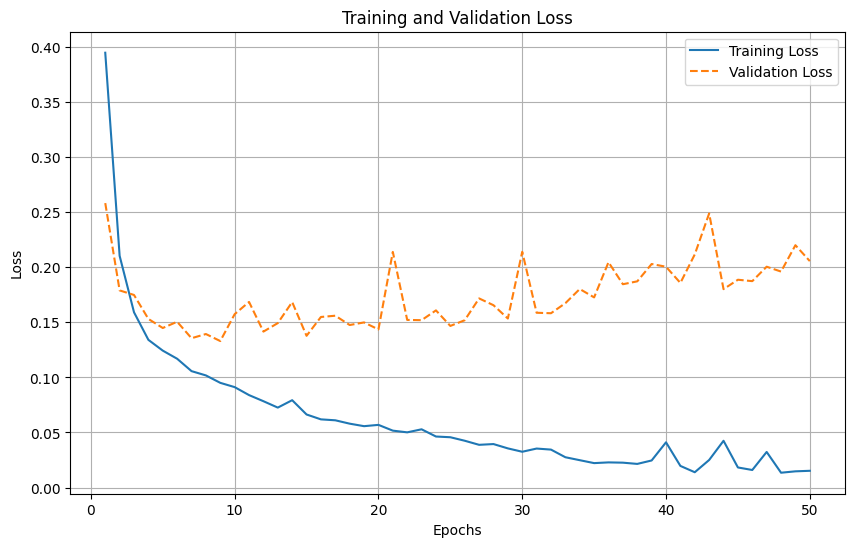

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses_dxdy, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses_dxdy, label="Validation Loss", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

Evaluation of the model

Test Accuracy: 0.95
Test Precision: 0.95
Test Recall: 0.95


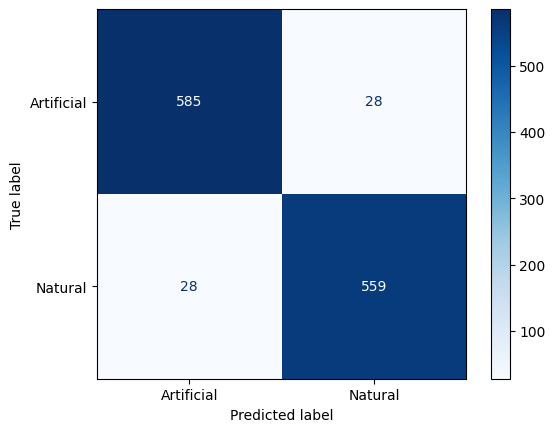

In [29]:
evaluate_model(model_dxdy, X_test_dxdy, y_test_dxdy)

### Rb histograms

In [30]:
scaler = StandardScaler()
X_rb_normalized = scaler.fit_transform(X_rb)

Sets creation and conversion to tensors

In [31]:
X_train_rb, X_test_rb, y_train_rb, y_test_rb = train_test_split(X_rb_normalized, y_rb, test_size=0.2, random_state=42)

X_train_rb, X_val_rb, y_train_rb, y_val_rb = train_test_split(X_train_rb, y_train_rb, test_size=0.25, random_state=42)

print(f"Train size: {X_train_rb.shape[0]}")
print(f"Validation size: {X_val_rb.shape[0]}")
print(f"Test size: {X_test_rb.shape[0]}")

X_train_rb = torch.tensor(X_train_rb, dtype=torch.float32)
X_val_rb = torch.tensor(X_val_rb, dtype=torch.float32)
X_test_rb = torch.tensor(X_test_rb, dtype=torch.float32).unsqueeze(1)

y_train_rb = torch.tensor(y_train_rb, dtype=torch.float32)
y_val_rb = torch.tensor(y_val_rb, dtype=torch.float32).unsqueeze(1)
y_test_rb = torch.tensor(y_test_rb, dtype=torch.float32).unsqueeze(1)

Train size: 3600
Validation size: 1200
Test size: 1200


Training

In [32]:
input_size = 100
hidden_size = 64
num_epochs = 50
batch_size = 32

model_rb = HistogramClassifier(input_size=input_size, hidden_size=hidden_size)

criterion = nn.BCELoss()
optimizer = optim.Adam(model_rb.parameters(), lr=0.001)

model_rb, train_losses_rb, val_losses_rb = train_model(
    model_rb, criterion,
    optimizer,
    X_train_rb,
    y_train_rb,
    X_val_rb,
    y_val_rb,
    num_epochs=num_epochs,
    batch_size=batch_size
)

Epoch 1/50, Loss: 0.28018295764923096, Val Loss: 0.44995447993278503
Epoch 2/50, Loss: 0.42194703221321106, Val Loss: 0.423280268907547
Epoch 3/50, Loss: 0.41441529989242554, Val Loss: 0.3997487723827362
Epoch 4/50, Loss: 0.29339322447776794, Val Loss: 0.3836522102355957
Epoch 5/50, Loss: 0.5431185364723206, Val Loss: 0.3782896101474762
Epoch 6/50, Loss: 0.22213709354400635, Val Loss: 0.37121352553367615
Epoch 7/50, Loss: 0.26917368173599243, Val Loss: 0.3707979917526245
Epoch 8/50, Loss: 0.33268576860427856, Val Loss: 0.36686578392982483
Epoch 9/50, Loss: 0.25380849838256836, Val Loss: 0.360099196434021
Epoch 10/50, Loss: 0.4434499442577362, Val Loss: 0.36204051971435547
Epoch 11/50, Loss: 0.5181452631950378, Val Loss: 0.3644169270992279
Epoch 12/50, Loss: 0.3218948245048523, Val Loss: 0.3577430844306946
Epoch 13/50, Loss: 0.49356696009635925, Val Loss: 0.36245283484458923
Epoch 14/50, Loss: 0.23846834897994995, Val Loss: 0.3662114441394806
Epoch 15/50, Loss: 0.3192649483680725, Val L

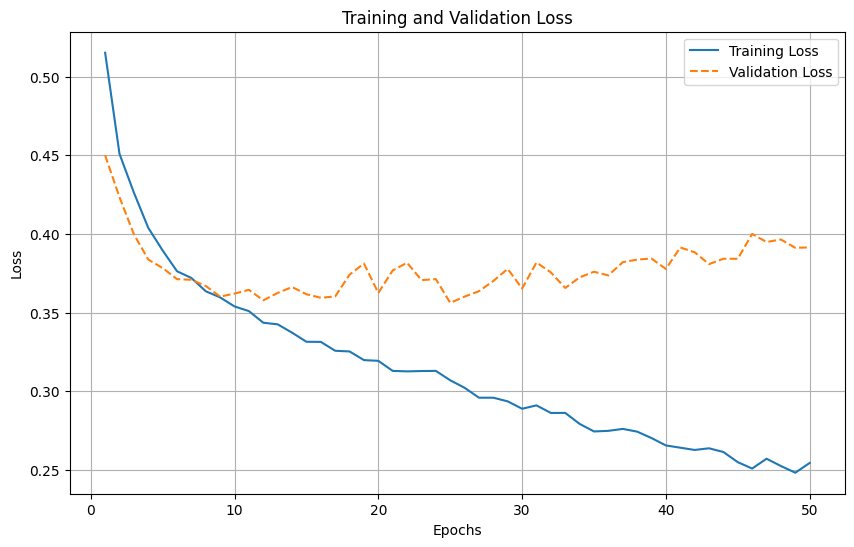

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses_rb, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses_rb, label="Validation Loss", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

Results evaluation

Test Accuracy: 0.83
Test Precision: 0.84
Test Recall: 0.81


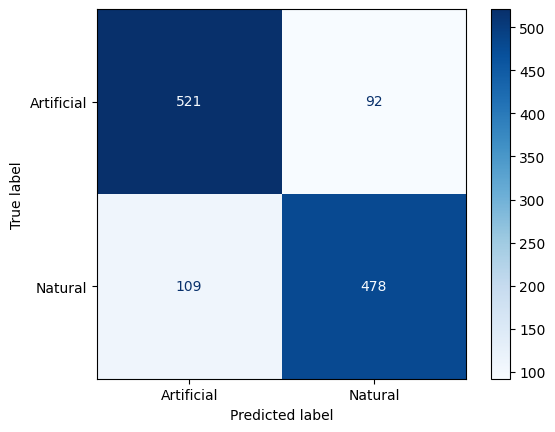

In [34]:
evaluate_model(model_rb, X_test_rb, y_test_rb)